# Working with Azure Machine Learning Studio engine

This notebook shows how to monitor the model deployed on Azure Machine Learning Studio using Watson OpenScale python sdk.

Contents

1. Setup
2. Binding machine learning engine
3. Subscriptions
4. Performance monitor, scoring and payload logging
5. Quality monitor and feedback logging
6. Fairness, Drift monitor and explainability
7. Payload analytics

<a id="setup"></a>
## 1. Setup

### Sample model creation using [Azure Machine Learning Studio](https://studio.azureml.net)

- Download training data set from [here](https://github.com/pmservice/wml-sample-models/raw/master/spark/product-line-prediction/data/GoSales_Tx.csv)
- Copy [credit risk experiment](https://gallery.cortanaintelligence.com/Experiment/German-credit-risk-created-on-1-9-2019) from Azure ML Studio Gallery 
- Run experiment to train a model
- Create (deploy) web service (new)

**NOTE:** Classic web services are not supported.

### Installation and authentication

In [1]:
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
!pip install --upgrade pyspark --no-cache | tail -n 1
!pip install --upgrade lime==0.1.1.32 --no-cache | tail -n 1

**Action:** Restart the kernel (Kernel->Restart)

Import and initiate.

In [2]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.supporting_classes import PayloadRecord
from ibm_ai_openscale.supporting_classes.enums import InputDataType, ProblemType
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *

#### ACTION: Get Watson OpenScale `apikey`

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using bluemix console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [3]:
API_KEY = 'USE IBM CLOUD API KEY'

In [4]:
# The code was removed by Watson Studio for sharing.

#### Let's define some constants required to set up data mart:

- AIOS_CREDENTIALS
- POSTGRES_CREDENTIALS
- SCHEMA_NAME

In [5]:
from ibm_ai_openscale.utils import get_instance_guid

AIOS_CREDENTIALS = {
  "url": "https://api.aiopenscale.cloud.ibm.com",
  "instance_guid": get_instance_guid(api_key=API_KEY),
  "apikey": API_KEY
}

In [6]:
POSTGRES_CREDENTIALS = {
    "db_type": "postgresql",
    "uri_cli_1": "xxx",
    "maps": [],
    "instance_administration_api": {
        "instance_id": "xxx",
        "root": "xxx",
        "deployment_id": "xxx"
    },
    "name": "xxx",
    "uri_cli": "xxx",
    "uri_direct_1": "xxx",
    "ca_certificate_base64": "xxx",
    "deployment_id": "xxx",
    "uri": "xxx"
}

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
SCHEMA_NAME = 'azure_dm'

Create schema for data mart.

In [9]:
create_postgres_schema(postgres_credentials=POSTGRES_CREDENTIALS, schema_name=SCHEMA_NAME)

In [10]:
client = APIClient(AIOS_CREDENTIALS)

In [11]:
client.version

'2.2.1'

#### Download and preview training data set

In [12]:
!rm -rf credit_risk_training.csv
!wget "https://raw.githubusercontent.com/pmservice/wml-sample-models/master/spark/credit-risk/data/credit_risk_training.csv"

--2020-04-01 18:43:42--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/spark/credit-risk/data/credit_risk_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694222 (678K) [text/plain]
Saving to: ‘credit_risk_training.csv’

100%[======================================>] 694,222     --.-K/s   in 0.04s   

2020-04-01 18:43:42 (16.3 MB/s) - ‘credit_risk_training.csv’ saved [694222/694222]



In [13]:
import pandas as pd

training_data_pd = pd.read_csv(
        "credit_risk_training.csv",
        dtype={'LoanDuration': int, 'LoanAmount': int, 'InstallmentPercent': int, 'CurrentResidenceDuration': int, 'Age': int, 'ExistingCreditsCount': int, 'Dependents': int})

In [14]:
training_data_pd.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


### DataMart setup

In [15]:
client.data_mart.setup(db_credentials=POSTGRES_CREDENTIALS, schema=SCHEMA_NAME)

In [16]:
data_mart_details = client.data_mart.get_details()

<a id="binding"></a>
## 2. Bind machine learning engines

### Bind  `Azure` machine learning studio

Provide credentials using following fields:
- `client_id`
- `client_secret`
- `subscription_id`
- `tenant`

In [17]:
AZURE_ENGINE_CREDENTIALS = {
    "client_id": "***",
    "client_secret": "***",
    "subscription_id": "***",
    "tenant": "***"
}

In [18]:
# The code was removed by Watson Studio for sharing.

In [19]:
binding_uid = client.data_mart.bindings.add('My Azure ML Studio engine', AzureMachineLearningStudioInstance(AZURE_ENGINE_CREDENTIALS))

In [20]:
bindings_details = client.data_mart.bindings.get_details()

In [21]:
client.data_mart.bindings.list()

6ac4d3c4-862f-4702-8053-9f531466686a,My Azure ML Studio engine,azure_machine_learning,2020-04-01T18:44:08.993Z
87d766e0-8b4d-42fd-85c1-c313f189d411,WML Instance,watson_machine_learning,2020-03-06T21:02:52.670Z


<a id="subsciption"></a>
## 3. Subscriptions

### Add subscriptions

List available deployments.

**Note:** Depending on number of assets it may take some time.

In [22]:
client.data_mart.bindings.list_assets(binding_uid=binding_uid)

2e0bf2a9b0567d419d37b3f992d40749,balancescale.multiclass,2019-06-06T02:17:19.3204159Z,model,,6ac4d3c4-862f-4702-8053-9f531466686a,False
5acb22f1b2d22b6ecb44d5bac5d6f44f,bankmarket.binary,2019-05-28T14:50:01.6576057Z,model,,6ac4d3c4-862f-4702-8053-9f531466686a,False
6a3f4095de199d0e35a8ede7d72a491f,loanlogisticregression,2019-05-24T12:12:46.4120458Z,model,,6ac4d3c4-862f-4702-8053-9f531466686a,False
3f3bb16a7bc9971fecbe9045bea764fd,lendingclub.loan.multiclass,2019-05-15T14:16:40.4861116Z,model,,6ac4d3c4-862f-4702-8053-9f531466686a,False
8b3fa6de5b35bb77fdc640877f5ee16b,forestcover.multiclass,2019-05-15T09:52:01.6785081Z,model,,6ac4d3c4-862f-4702-8053-9f531466686a,False
417532dc6dae852809393ae097703de5,adultcensusincome.logistic.regression,2019-05-08T08:09:09.3483819Z,model,,6ac4d3c4-862f-4702-8053-9f531466686a,False
690e5e9d2c03859de56a0c7570097ec7,incomeprediction.census,2019-05-07T17:12:53.5401795Z,model,,6ac4d3c4-862f-4702-8053-9f531466686a,False
31816b6dfa672e0d18dd0485cb82c4be,bikerental.linear.regression,2019-05-07T16:25:47.8119975Z,model,,6ac4d3c4-862f-4702-8053-9f531466686a,False
20a23d9de1ab5762b880d7bc4ce09ff2,videogameverdict.binary,2019-05-06T17:05:16.3846249Z,model,,6ac4d3c4-862f-4702-8053-9f531466686a,False
78108c0d5e657065f65c7217b90351bd,letterrecognition.multiclass,2019-05-06T16:58:04.7056361Z,model,,6ac4d3c4-862f-4702-8053-9f531466686a,False
5202b312258ed793823d67c6ece36987,bikerental.regression,2019-05-06T16:51:07.9481437Z,model,,6ac4d3c4-862f-4702-8053-9f531466686a,False


**Action:** Assign your credit risk source_uid to `source_uid` variable below.

In [23]:
source_uid = '085460ef94636166aea5800e9ea26168'

In [24]:
feature_columns = ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker']
categorical_columns = ['CheckingStatus', 'CreditHistory', 'LoanPurpose', 'ExistingSavings', 'EmploymentDuration', 'Sex', 'OthersOnLoan', 'OwnsProperty', 'InstallmentPlans', 'Housing', 'Job', 'Telephone', 'ForeignWorker']

In [25]:
subscription = client.data_mart.subscriptions.add(
    AzureMachineLearningStudioAsset(source_uid=source_uid,
                                      binding_uid=binding_uid,
                                      input_data_type=InputDataType.STRUCTURED,
                                      problem_type=ProblemType.BINARY_CLASSIFICATION,
                                      label_column='Risk',
                                      prediction_column='Scored Labels',
                                      probability_column='Scored Probabilities',
                                      feature_columns=feature_columns,
                                      categorical_columns=categorical_columns))

### Get subscriptions list

In [26]:
subscriptions = client.data_mart.subscriptions.get_details()

In [27]:
subscriptions_uids = client.data_mart.subscriptions.get_uids()
print(subscriptions_uids)

['7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f']


### List subscriptions

In [28]:
client.data_mart.subscriptions.list()

7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,GermanCreditRisk.2019.1.9.10.41.58.611,model,6ac4d3c4-862f-4702-8053-9f531466686a,2020-04-01T18:45:23.693Z


<a id="scoring"></a>
## 4. Scoring and payload logging

### Score the credit risk model and measure response time

In [29]:
import requests
import time
import json

subscription_details = subscription.get_details()
scoring_url = subscription_details['entity']['deployments'][0]['scoring_endpoint']['url']

data = {
            "Inputs": {
                "input1":
                    [
                        {
                            'CheckingStatus': "0_to_200", 'LoanDuration': 31, 'CreditHistory': "credits_paid_to_date", 'LoanPurpose': "other",
                            'LoanAmount': 1889, 'ExistingSavings': "100_to_500",'EmploymentDuration': "less_1",'InstallmentPercent': 3,'Sex': "female",
                            'OthersOnLoan': "none",'CurrentResidenceDuration': 3, 'OwnsProperty': "savings_insurance", 'Age': 32,'InstallmentPlans': "none",
                            'Housing': "own",'ExistingCreditsCount': 1,'Job': "skilled",'Dependents': 1,'Telephone': "none",'ForeignWorker': "yes",
                        },
                        {
                            'CheckingStatus': "no_checking", 'LoanDuration': 13, 'CreditHistory': "credits_paid_to_date", 'LoanPurpose': "car_new",
                            'LoanAmount': 1389, 'ExistingSavings': "100_to_500",'EmploymentDuration': "1_to_4",'InstallmentPercent': 2,'Sex': "male",
                            'OthersOnLoan': "none",'CurrentResidenceDuration': 3, 'OwnsProperty': "savings_insurance", 'Age': 25,'InstallmentPlans': "none",
                            'Housing': "own",'ExistingCreditsCount': 2,'Job': "skilled",'Dependents': 1,'Telephone': "none",'ForeignWorker': "yes",
                        }
                    ],
            },
            "GlobalParameters": {
            }
        }

body = str.encode(json.dumps(data))

token = subscription_details['entity']['deployments'][0]['scoring_endpoint']['credentials']['token']
headers = subscription_details['entity']['deployments'][0]['scoring_endpoint']['request_headers']
headers['Authorization'] = ('Bearer ' + token)

start_time = time.time()
response = requests.post(url=scoring_url, data=body, headers=headers)
response_time = int(time.time() - start_time)*1000
result = response.json()

print(json.dumps(result, indent=2))

{
  "Results": {
    "output1": [
      {
        "CheckingStatus": "0_to_200",
        "LoanDuration": "31",
        "CreditHistory": "credits_paid_to_date",
        "LoanPurpose": "other",
        "LoanAmount": "1889",
        "ExistingSavings": "100_to_500",
        "EmploymentDuration": "less_1",
        "InstallmentPercent": "3",
        "Sex": "female",
        "OthersOnLoan": "none",
        "CurrentResidenceDuration": "3",
        "OwnsProperty": "savings_insurance",
        "Age": "32",
        "InstallmentPlans": "none",
        "Housing": "own",
        "ExistingCreditsCount": "1",
        "Job": "skilled",
        "Dependents": "1",
        "Telephone": "none",
        "ForeignWorker": "yes",
        "Scored Labels": "No Risk",
        "Scored Probabilities": "0.0140035906806588"
      },
      {
        "CheckingStatus": "no_checking",
        "LoanDuration": "13",
        "CreditHistory": "credits_paid_to_date",
        "LoanPurpose": "car_new",
        "LoanAmount": "138

### Store the request and response in payload logging table

In [30]:
records_list = []

for i in range(1, 10):
    records_list.append(PayloadRecord(request=data, response=result, response_time=response_time))

subscription.payload_logging.store(records=records_list)

In [31]:
import time

time.sleep(5)
subscription.payload_logging.describe_table()

       LoanDuration   LoanAmount  InstallmentPercent  \
count     18.000000    18.000000           18.000000   
mean      22.000000  1639.000000            2.500000   
std        9.260924   257.247878            0.514496   
min       13.000000  1389.000000            2.000000   
25%       13.000000  1389.000000            2.000000   
50%       22.000000  1639.000000            2.500000   
75%       31.000000  1889.000000            3.000000   
max       31.000000  1889.000000            3.000000   

       CurrentResidenceDuration       Age  ExistingCreditsCount  Dependents  \
count                      18.0  18.00000             18.000000        18.0   
mean                        3.0  28.50000              1.500000         1.0   
std                         0.0   3.60147              0.514496         0.0   
min                         3.0  25.00000              1.000000         1.0   
25%                         3.0  25.00000              1.000000         1.0   
50%                  

### Check transactions performance data

In [32]:
subscription.performance_monitoring.show_table()

2020-04-01 18:45:38.121000+00:00,0.0,2,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad,,
2020-04-01 18:45:38.121000+00:00,0.0,2,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad,,
2020-04-01 18:45:38.121000+00:00,0.0,2,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad,,
2020-04-01 18:45:38.121000+00:00,0.0,2,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad,,
2020-04-01 18:45:38.121000+00:00,0.0,2,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad,,
2020-04-01 18:45:38.121000+00:00,0.0,2,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad,,
2020-04-01 18:45:38.121000+00:00,0.0,2,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad,,
2020-04-01 18:45:38.121000+00:00,0.0,2,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad,,
2020-04-01 18:45:38.121000+00:00,0.0,2,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad,,


**Note:** It may take few seconds before performance data is populated.

<a id="feedback"></a>
## 5. Feedback logging & quality (accuracy) monitoring

### Enable quality monitoring

You need to provide the monitoring `threshold` and `min_records` (minimal number of feedback records).

In [33]:
subscription.quality_monitoring.enable(threshold=0.7, min_records=10)

### Feedback records logging

Feedback records are used to evaluate your model. The predicted values are compared to real values (feedback records).

You can check the schema of feedback table using below method.

In [34]:
subscription.feedback_logging.print_table_schema()

CheckingStatus,string,True
LoanDuration,integer,True
CreditHistory,string,True
LoanPurpose,string,True
LoanAmount,integer,True
ExistingSavings,string,True
EmploymentDuration,string,True
InstallmentPercent,integer,True
Sex,string,True
OthersOnLoan,string,True
CurrentResidenceDuration,integer,True


The feedback records can be send to feedback table using below code.

In [35]:
records = [
    ["no_checking","28","outstanding_credit","appliances","5990","500_to_1000","greater_7","5","male","co-applicant","3","car_other","55","none","free","2","skilled","2","yes","yes","Risk"],
    ["greater_200","22","all_credits_paid_back","car_used","3376","less_100","less_1","3","female","none","2","car_other","32","none","own","1","skilled","1","none","yes","No Risk"],
    ["no_checking","39","credits_paid_to_date","vacation","6434","unknown","greater_7","5","male","none","4","car_other","39","none","own","2","skilled","2","yes","yes","Risk"],
    ["0_to_200","20","credits_paid_to_date","furniture","2442","less_100","unemployed","3","female","none","1","real_estate","42","none","own","1","skilled","1","none","yes","No Risk"],
    ["greater_200","4","all_credits_paid_back","education","4206","less_100","unemployed","1","female","none","3","savings_insurance","27","none","own","1","management_self-employed","1","none","yes","No Risk"],
    ["greater_200","23","credits_paid_to_date","car_used","2963","greater_1000","greater_7","4","male","none","4","car_other","46","none","own","2","skilled","1","none","yes","Risk"],
    ["no_checking","31","prior_payments_delayed","vacation","2673","500_to_1000","1_to_4","3","male","none","2","real_estate","35","stores","rent","1","skilled","2","none","yes","Risk"],
    ["no_checking","37","prior_payments_delayed","other","6971","500_to_1000","1_to_4","3","male","none","3","savings_insurance","54","none","own","2","skilled","1","yes","yes","Risk"],
    ["0_to_200","39","prior_payments_delayed","appliances","5685","100_to_500","1_to_4","4","female","none","2","unknown","37","none","own","2","skilled","1","yes","yes","Risk"],
    ["no_checking","38","prior_payments_delayed","appliances","4990","500_to_1000","greater_7","4","male","none","4","car_other","50","bank","own","2","unemployed","2","yes","yes","Risk"]]

fields = feature_columns.copy()
fields.append('Risk')

subscription.feedback_logging.store(feedback_data=records, fields=fields)

### Run quality monitoring on demand

By default, quality monitoring is run on hourly schedule. You can also trigger it on demand using below code.

In [36]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run 61a40239-55eb-4ffe-86fe-3ca542be14cd 




completed

---------------------------
 Successfully finished run 
---------------------------




### Show the quality metrics

In [37]:
subscription.quality_monitoring.show_table()

2020-04-01 18:46:29.070000+00:00,true_positive_rate,999201ac-c64b-4316-bdfa-d1d203fdad48,0.8571428571428571,,,model_type: original,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad
2020-04-01 18:46:29.070000+00:00,area_under_roc,999201ac-c64b-4316-bdfa-d1d203fdad48,0.9285714285714286,0.7,,model_type: original,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad
2020-04-01 18:46:29.070000+00:00,precision,999201ac-c64b-4316-bdfa-d1d203fdad48,1.0,,,model_type: original,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad
2020-04-01 18:46:29.070000+00:00,f1_measure,999201ac-c64b-4316-bdfa-d1d203fdad48,0.923076923076923,,,model_type: original,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad
2020-04-01 18:46:29.070000+00:00,accuracy,999201ac-c64b-4316-bdfa-d1d203fdad48,0.9,,,model_type: original,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad
2020-04-01 18:46:29.070000+00:00,log_loss,999201ac-c64b-4316-bdfa-d1d203fdad48,0.10192821288228596,,,model_type: original,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad
2020-04-01 18:46:29.070000+00:00,false_positive_rate,999201ac-c64b-4316-bdfa-d1d203fdad48,0.0,,,model_type: original,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad
2020-04-01 18:46:29.070000+00:00,area_under_pr,999201ac-c64b-4316-bdfa-d1d203fdad48,0.9785714285714285,,,model_type: original,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad
2020-04-01 18:46:29.070000+00:00,recall,999201ac-c64b-4316-bdfa-d1d203fdad48,0.8571428571428571,,,model_type: original,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad


Get all calculated metrics.

In [38]:
deployment_uids = subscription.get_deployment_uids()

In [39]:
metrics = subscription.quality_monitoring.get_metrics(deployment_uid=deployment_uids[0])
print(json.dumps(metrics, indent=2))

[
  {
    "asset_id": "085460ef94636166aea5800e9ea26168",
    "binding_id": "6ac4d3c4-862f-4702-8053-9f531466686a",
    "tags": [
      {
        "id": "model_type",
        "value": "original"
      }
    ],
    "ts": "2020-04-01T18:46:29.070Z",
    "measurement_id": "999201ac-c64b-4316-bdfa-d1d203fdad48",
    "monitor_definition_id": "quality",
    "subscription_id": "7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f",
    "metrics": [
      {
        "id": "true_positive_rate",
        "value": 0.8571428571428571
      },
      {
        "lower_limit": 0.7,
        "id": "area_under_roc",
        "value": 0.9285714285714286
      },
      {
        "id": "precision",
        "value": 1.0
      },
      {
        "id": "f1_measure",
        "value": 0.923076923076923
      },
      {
        "id": "accuracy",
        "value": 0.9
      },
      {
        "id": "log_loss",
        "value": 0.10192821288228596
      },
      {
        "id": "false_positive_rate",
        "value": 0.0
      },
     

### Get metrics as pandas dataframe

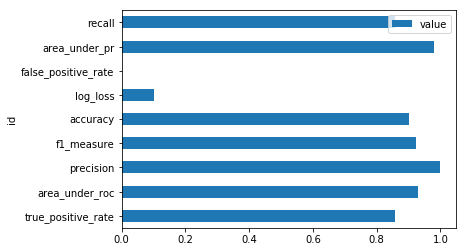

In [40]:
quality_metrics_pandas = subscription.quality_monitoring.get_table_content()

%matplotlib inline
quality_metrics_pandas.plot.barh(x='id', y='value');

## 6. Fairness, Drift monitoring and explanations

### Fairness monitor configuration

In [41]:
from ibm_ai_openscale.supporting_classes.feature import Feature

subscription.fairness_monitoring.enable(
            training_data=training_data_pd,
            features=[
                Feature("Sex", majority=['male'], minority=['female'], threshold=0.95),
                Feature("Age", majority=[[26, 75]], minority=[[18, 25]], threshold=0.95)
            ],
            favourable_classes=['No Risk'],
            unfavourable_classes=['Risk'],
            min_records=5
        )

### Run fairness monitor on demand

In [42]:
fairness_run = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=563f01d37f720857b95c557dc76176ad 




RUNNING
FINISHED

---------------------------
 Successfully finished run 
---------------------------




### Show run results

In [43]:
subscription.fairness_monitoring.show_table()

2020-04-01 18:47:05.781993+00:00,Sex,female,False,1.0,100.0,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad,
2020-04-01 18:47:05.781993+00:00,Age,"[18, 25]",False,1.667,100.0,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad,


### Explainability configuration

In [49]:
subscription.explainability.enable(training_data=training_data_pd)

### Run explanation

Get sample transaction/scoring id. You can also use `subscription.payload_logging.show_table()` to see list of your transactions (`scoring_id` column).

In [50]:
transaction_id = subscription.payload_logging.get_table_content(limit=1)['scoring_id'][0]
print('Sample transaction/scoring id: ', transaction_id)

Sample transaction/scoring id:  219dbfc5-18e7-48cf-bcab-94de377ec475-1


In [51]:
explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False)




 Looking for explanation for 219dbfc5-18e7-48cf-bcab-94de377ec475-1 




in_progress..
finished

---------------------------
 Successfully finished run 
---------------------------




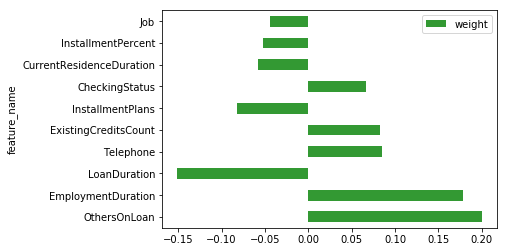

In [52]:
explanation_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])
explanation_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);

### Drift monitor configuration

#### Drift requires a trained model to be uploaded manually for Azure. You can train, create and download a drift detection model using template given ( check for Drift detection model generation) [here](https://github.com/IBM-Watson/aios-data-distribution/blob/master/training_statistics_notebook.ipynb)

In [44]:
!rm -rf creditrisk_azure_drift_detection_model.tar.gz
!wget -O creditrisk_azure_drift_detection_model.tar.gz https://github.com/pmservice/ai-openscale-tutorials/blob/master/assets/models/creditrisk_azure_drift_detection_model.tar.gz?raw=true 

--2020-04-01 18:47:33--  https://github.com/pmservice/ai-openscale-tutorials/blob/master/assets/models/creditrisk_azure_drift_detection_model.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pmservice/ai-openscale-tutorials/raw/master/assets/models/creditrisk_azure_drift_detection_model.tar.gz [following]
--2020-04-01 18:47:33--  https://github.com/pmservice/ai-openscale-tutorials/raw/master/assets/models/creditrisk_azure_drift_detection_model.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/models/creditrisk_azure_drift_detection_model.tar.gz [following]
--2020-04-01 18:47:33--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/models/creditrisk_az

In [45]:
subscription.drift_monitoring.enable(threshold=0.1, min_records=5,model_path="creditrisk_azure_drift_detection_model.tar.gz")

{'config_status': {'state': 'finished'},
 'data_drift_enabled': True,
 'drift_threshold': 0.1,
 'is_schedule_enabled': True,
 'min_samples': 5,
 'model_drift_enabled': True,
 'next_scheduled_run_timestamp': '2020-04-01T18:49:38.709431Z',
 'schedule_repeat_interval': 3,
 'schedule_repeat_type': 'hour'}

### Run Drift monitor on demand

In [46]:
drift_run_details = subscription.drift_monitoring.run(background_mode=False)




 Waiting for end of drift monitoring run  




RUNNING
COMPLETED

---------------------------
 Successfully finished run 
---------------------------




In [47]:
subscription.drift_monitoring.get_table_content()

,ts,id,measurement_id,value,lower limit,upper limit,tags,binding_id,subscription_id,deployment_id
0,2020-04-01 18:47:51.233402+00:00,data_drift_magnitude,f181bb7a-359c-4efe-88b1-23e660cdd0eb,0.000,,,,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad
1,2020-04-01 18:47:51.233402+00:00,drift_magnitude,f181bb7a-359c-4efe-88b1-23e660cdd0eb,0.413,,0.1,,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad
2,2020-04-01 18:47:51.233402+00:00,predicted_accuracy,f181bb7a-359c-4efe-88b1-23e660cdd0eb,0.500,,,,6ac4d3c4-862f-4702-8053-9f531466686a,7c3a3f6c-b11c-4d38-a7ca-a179227f5f9f,563f01d37f720857b95c557dc76176ad


## 7. Payload analytics

### Run data distributions calculation

In [48]:
from datetime import datetime

start_date = "2018-01-01T00:00:00.00Z"
end_date = datetime.utcnow().isoformat() + "Z"

sex_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['Scored Labels', 'Sex'],
            agg=['count'])




 Waiting for end of data distribution run 04e01728-bf9d-4e69-aa45-8f50d27af8aa 




completed

---------------------------
 Successfully finished run 
---------------------------




### Get data distributions as pandas dataframe

In [49]:
sex_distribution_run_uid = sex_distribution['id']

In [50]:
distributions_pd = subscription.payload_logging.data_distribution.get_run_result(run_id=sex_distribution_run_uid, format='pandas')
distributions_pd

,Scored Labels,Sex,count
0,No Risk,female,9
1,No Risk,male,9


### Visualize

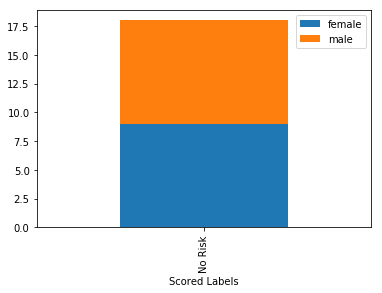

In [51]:
subscription.payload_logging.data_distribution.show_chart(sex_distribution_run_uid);

---

## Congratulations!

You have finished the tutorial for IBM Watson OpenScale and Azure Machine Learning Studio. You can now view the [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). Click on the tile for the German Credit model to see fairness, accuracy, and performance monitors. Click on the timeseries graph to get detailed information on transactions during a specific time window.



---

### Authors
Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Rounok Salehin,Data Scientist and Cognitive Developer at IBM with experties in enterprise-level machine learning/AI applications development emphasize on turning data into descriptive/actionable outcomes.